In [1]:
import cv2
import numpy as np
import os

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### completed tasks:
#### successfully rotated/translated/flipped image 
#### started patching across diff stains

### rotating tif masks

In [3]:
def clean_edges(edges):
    blurred = cv2.GaussianBlur(edges, (5, 5), 0)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilated = cv2.dilate(blurred, kernel, iterations=1)
    cleaned_edges = cv2.erode(dilated, kernel, iterations=1)
    return cleaned_edges

# Find the largest contour by area
def find_largest_contour(contours):
    largest_contour = max(contours, key=cv2.contourArea)
    return largest_contour

# Fill a contour to create a mask of the shape
def fill_contour(img_shape, contour):
    mask = np.zeros(img_shape, dtype=np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
    return mask

# Calculate the center of mass of a filled contour
def get_center_of_mass(mask):
    M = cv2.moments(mask)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = mask.shape[1] // 2, mask.shape[0] // 2  # Default to center if no mass
    return cX, cY

# Center the image based on center of mass
def center_image(mask):
    cX, cY = get_center_of_mass(mask)
    shiftX = mask.shape[1] // 2 - cX
    shiftY = mask.shape[0] // 2 - cY
    translation_matrix = np.float32([[1, 0, shiftX], [0, 1, shiftY]])
    centered_mask = cv2.warpAffine(mask, translation_matrix, (mask.shape[1], mask.shape[0]))
    return centered_mask

# Combines the above functions for the pipeline
def pipeline_helper(tif_path):
    image = cv2.imread(tif_path, 0)
    edges = cv2.Canny(image, 50, 100)
    cleaned_edges = clean_edges(edges)
    contours, _ = cv2.findContours(cleaned_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = find_largest_contour(contours)
    mask = fill_contour(cleaned_edges.shape, largest_contour)
    centered_mask = center_image(mask)
    return centered_mask

In [4]:
# Rotate the image around its center
def rotate_image(image, angle):
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h))
    return rotated_image

# Pad an image symmetrically to match the target size
def pad_to_size(image, target_size):
    h, w = image.shape[:2]
    pad_top = (target_size[1] - h) // 2
    pad_bottom = target_size[1] - h - pad_top
    pad_left = (target_size[0] - w) // 2
    pad_right = target_size[0] - w - pad_left
    padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant', constant_values=0)
    return padded_image


In [5]:
# Mirror the image either horizontally or vertically
def mirror_image(image, direction='horizontal'):
    if direction == 'horizontal':
        mirrored_image = cv2.flip(image, 1)  # Horizontal flip
    elif direction == 'vertical':
        mirrored_image = cv2.flip(image, 0)  # Vertical flip
    else:
        raise ValueError("Direction should be either 'horizontal' or 'vertical'")
    return mirrored_image

# Function to find the optimal rotation and flip for alignment
def find_best_rotation_with_flip(mask1, mask2, angles=np.arange(-90, 91, 1)):
    best_overlap = 0
    best_angle = 0
    best_flip = None

    for flip in [None, 'horizontal', 'vertical']:
        flipped_mask2 = mirror_image(mask2, flip) if flip else mask2
        for angle in angles:
            rotated_mask2 = rotate_image(flipped_mask2, angle)
            intersection = cv2.bitwise_and(mask1, rotated_mask2)
            union = cv2.bitwise_or(mask1, rotated_mask2)
            similarity_score = np.sum(intersection) / np.sum(union)

            if similarity_score > best_overlap:
                best_overlap = similarity_score
                best_angle = angle
                best_flip = flip

    return best_overlap, best_angle, best_flip


In [6]:
# Main pipeline with optimal flip function
def pipeline_with_optimal_flip(path1, path2, path3):
    mask1 = pipeline_helper(path1)
    mask2 = pipeline_helper(path2)
    mask3 = pipeline_helper(path3)

    # Step 1: Get maximum width and height to resize all three images
    max_width = max(mask1.shape[1], mask2.shape[1], mask3.shape[1])
    max_height = max(mask1.shape[0], mask2.shape[0], mask3.shape[0])

    # Step 2: Resize and pad all masks to the same size
    mask1 = pad_to_size(mask1, (max_width, max_height))
    mask2 = pad_to_size(mask2, (max_width, max_height))
    mask3 = pad_to_size(mask3, (max_width, max_height))

    # Step 3: Find the best rotation and flip for mask2 that maximizes overlap with mask1
    best_overlap_2, angle2, flip2 = find_best_rotation_with_flip(mask1, mask2)
    mask2_flipped = mirror_image(mask2, flip2) if flip2 else mask2
    mask2_transformed = rotate_image(mask2_flipped, angle2)

    # Step 4: Find the best rotation and flip for mask3 that maximizes overlap with the transformed mask2
    best_overlap_3, angle3, flip3 = find_best_rotation_with_flip(mask1, mask3)
    mask3_flipped = mirror_image(mask3, flip3) if flip3 else mask3
    mask3_transformed = rotate_image(mask3_flipped, angle3)

    return mask1, mask2, mask3, mask2_transformed, mask3_transformed, angle2, flip2, angle3, flip3


In [7]:
paths = ['patient1/h1810898A h&e_ROI_1.tif', 'patient1/h1810898A mela_ROI_1.tif', 'patient1/h1810898A sox10_ROI_1.tif']

he, melana, sox, melana_rotated, sox_rotated, angle2, flip2, angle3, flip3 = pipeline_with_optimal_flip(paths[0], paths[1], paths[2])

In [8]:
# Create a 3x3 kernel for morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))


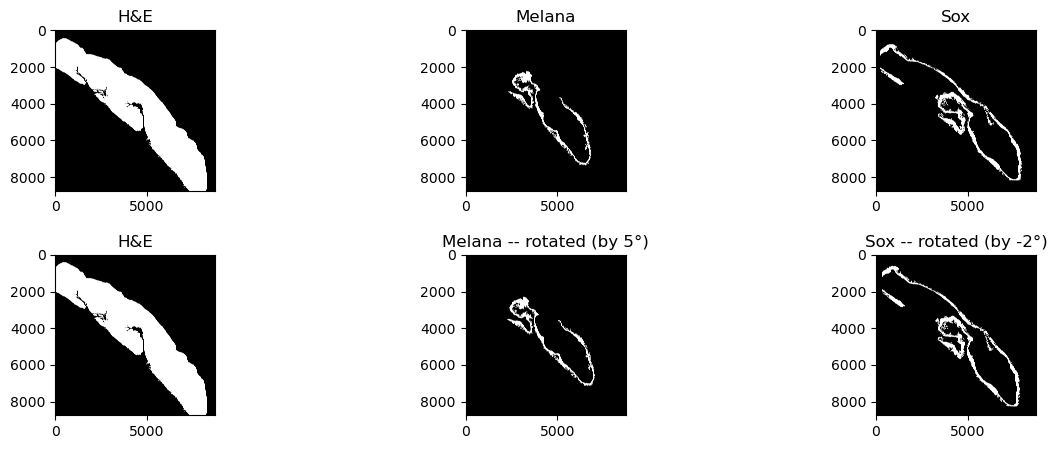

In [10]:
plt.figure(figsize=(15, 5))

# Original images
plt.subplot(2, 3, 1)
plt.title('H&E')
plt.imshow(he, cmap='gray')

plt.subplot(2, 3, 2)
plt.title('Melana')
plt.imshow(melana, cmap='gray')

plt.subplot(2, 3, 3)
plt.title('Sox')
plt.imshow(sox, cmap='gray')

# Transformed images with rotation and flip information
plt.subplot(2, 3, 4)
plt.title('H&E')
plt.imshow(he, cmap='gray')

# Show rotation and flip information for Melana
melana_flip_info = f", flipped {flip2}" if flip2 else ""
plt.subplot(2, 3, 5)
plt.title(f'Melana -- rotated (by {angle2}°{melana_flip_info})')
plt.imshow(melana_rotated, cmap='gray')

# Show rotation and flip information for Sox
sox_flip_info = f", flipped {flip3}" if flip3 else ""
plt.subplot(2, 3, 6)
plt.title(f'Sox -- rotated (by {angle3}°{sox_flip_info})')
plt.imshow(sox_rotated, cmap='gray')

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.4)

plt.show()


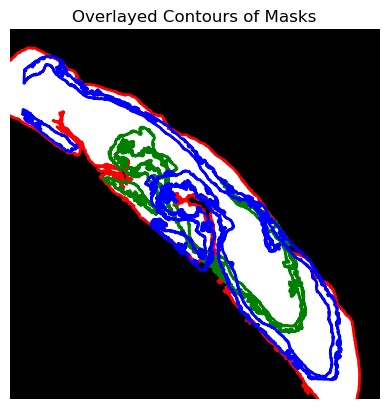

In [11]:
# Find contours for each mask
he_contours = find_contours(he, level=0.5)
melana_contours = find_contours(melana_rotated, level=0.5)
sox_contours = find_contours(sox_rotated, level=0.5)

# Plot the base image (you can choose to use one of the images or any other background)
plt.imshow(he, cmap='gray')  # Replace `he` with the desired base image

# Plot contours of each mask on top of the base image
for contour in he_contours:
    plt.plot(contour[:, 1], contour[:, 0], color='red', lw=2)  # Red contours for H&E

for contour in melana_contours:
    plt.plot(contour[:, 1], contour[:, 0], color='green', lw=2)  # Green contours for melana

for contour in sox_contours:
    plt.plot(contour[:, 1], contour[:, 0], color='blue', lw=2)  # Green contours for sox10

# Plot
plt.title('Overlayed Contours of Masks')
plt.axis('off')  # Hide axis
plt.show()


### example flipping

In [21]:
paths = ['patient1_flipped/h1810898A h&e_ROI_1.tif', 'patient1_flipped/h1810898A mela_ROI_1.tif', 'patient1_flipped/h1810898A sox10_ROI_1.tif']

he, melana, sox, melana_rotated, sox_rotated, angle2, flip2, angle3, flip3 = pipeline_with_optimal_flip(paths[0], paths[1], paths[2])

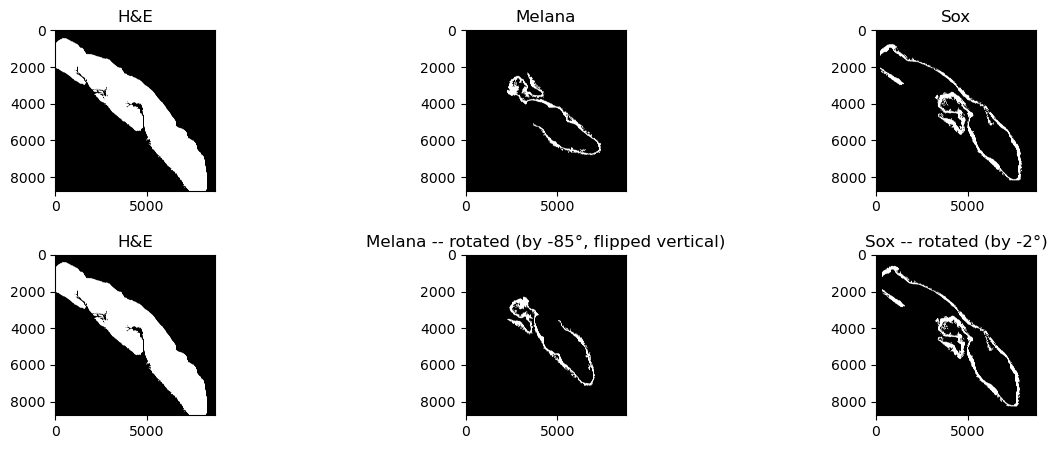

In [22]:
plt.figure(figsize=(15, 5))

# Original images
plt.subplot(2, 3, 1)
plt.title('H&E')
plt.imshow(he, cmap='gray')

plt.subplot(2, 3, 2)
plt.title('Melana')
plt.imshow(melana, cmap='gray')

plt.subplot(2, 3, 3)
plt.title('Sox')
plt.imshow(sox, cmap='gray')

# Transformed images with rotation and flip information
plt.subplot(2, 3, 4)
plt.title('H&E')
plt.imshow(he, cmap='gray')

# Show rotation and flip information for Melana
melana_flip_info = f", flipped {flip2}" if flip2 else ""
plt.subplot(2, 3, 5)
plt.title(f'Melana -- rotated (by {angle2}°{melana_flip_info})')
plt.imshow(melana_rotated, cmap='gray')

# Show rotation and flip information for Sox
sox_flip_info = f", flipped {flip3}" if flip3 else ""
plt.subplot(2, 3, 6)
plt.title(f'Sox -- rotated (by {angle3}°{sox_flip_info})')
plt.imshow(sox_rotated, cmap='gray')

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.4)

plt.show()

### patching - WIP !!!! but not a bad start

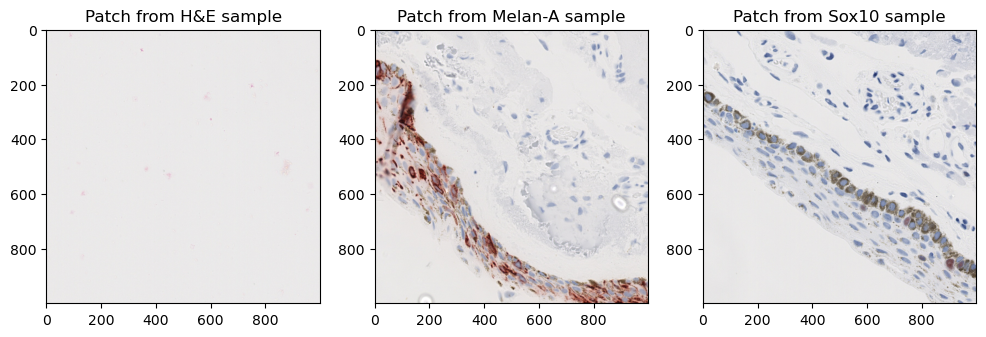

In [34]:
import random
# Function to clean the edges of the image
def clean_edges(edges):
    blurred = cv2.GaussianBlur(edges, (5, 5), 0)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilated = cv2.dilate(blurred, kernel, iterations=1)
    cleaned_edges = cv2.erode(dilated, kernel, iterations=1)
    return cleaned_edges

# Find the largest contour by area
def find_largest_contour(contours):
    largest_contour = max(contours, key=cv2.contourArea)
    return largest_contour

# Calculate the bounding box for the contour
def get_bounding_box(contour):
    x, y, w, h = cv2.boundingRect(contour)
    return x, y, w, h

# Function to extract a random patch from an image
def extract_random_patch(image, bounding_box, patch_size=(1000, 1000)):
    x, y, w, h = bounding_box
    max_x = x + w - patch_size[0]
    max_y = y + h - patch_size[1]
    
    if max_x <= x or max_y <= y:
        raise ValueError("Patch size is larger than the ROI!")

    # Randomly choose a starting point for the patch within the bounding box
    start_x = random.randint(x, max_x)
    start_y = random.randint(y, max_y)
    
    # Extract the patch
    patch = image[start_y:start_y+patch_size[1], start_x:start_x+patch_size[0]]
    return patch

# Main pipeline function for extracting patches
def extract_patches_from_images(paths, patch_size=(1000, 1000)):
    original_images = [cv2.imread(path) for path in paths]  # Load images in original color format

    # Process the first image (H&E) to find the contour and bounding box
    edges = cv2.Canny(original_images[0], 50, 100)
    cleaned_edges = clean_edges(edges)
    contours, _ = cv2.findContours(cleaned_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = find_largest_contour(contours)
    bounding_box = get_bounding_box(largest_contour)

    # Extract random patches from the H&E, Melana, and Sox images
    patches = []
    for img in original_images:
        patch = extract_random_patch(img, bounding_box, patch_size)
        patches.append(patch)
    
    return patches, bounding_box

# Example paths (replace with actual file paths)
paths = ['patient1/h1810898A h&e_ROI_1.tif', 'patient1/h1810898A mela_ROI_1.tif', 'patient1/h1810898A sox10_ROI_1.tif']

patches, bounding_box = extract_patches_from_images(paths)

# Visualize the patches extracted from the three images
plt.figure(figsize=(12, 4))

# Display patches in original color format
patch_titles = ['Patch from H&E sample', 'Patch from Melan-A sample', 'Patch from Sox10 sample']
for i, patch in enumerate(patches):
    plt.subplot(1, 3, i + 1)
    plt.imshow(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.title(patch_titles[i])

plt.show()


### rotating tif masks (he epithelium)

In [12]:
def generate_epithelium_mask(image_path):
    
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (45, 45), 0)
    _, thresholded_mask = cv2.threshold(blurred_image, 200, 255, cv2.THRESH_BINARY_INV)
    kernel_huge = np.ones((45, 45), np.uint8)
    cleaned_mask = cv2.morphologyEx(thresholded_mask, cv2.MORPH_CLOSE, kernel_huge)
    cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_OPEN, kernel_huge)

    kernel_medium = np.ones((25, 25), np.uint8)
    generalized_cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_CLOSE, kernel_medium)
    generalized_cleaned_mask = cv2.morphologyEx(generalized_cleaned_mask, cv2.MORPH_OPEN, kernel_medium)

    # Find contours for the generalized mask
    contours, _ = cv2.findContours(generalized_cleaned_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on a separate mask
    contour_mask = np.zeros_like(generalized_cleaned_mask)
    cv2.drawContours(contour_mask, contours, -1, 255, thickness=cv2.FILLED)
    
    return contour_mask, contours, image


# Creating Superpixels and Cutting Along Contour Boundaries

def create_and_cut_superpixels(image, contour_mask, contours, num_segments=750):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    segments = slic(image_rgb, n_segments=num_segments, compactness=10, start_label=1)
    
    segmented_image = np.zeros_like(image_rgb)
    lower_purple = np.array([125, 40, 40])
    upper_purple = np.array([155, 255, 255])

    for segment_value in np.unique(segments):
        segment_mask = (segments == segment_value)
        
        # Separate parts inside and outside the contour using the contour mask
        inside_mask = np.logical_and(segment_mask, contour_mask > 0)
        outside_mask = np.logical_and(segment_mask, contour_mask == 0)

        # Process inside region
        if np.sum(inside_mask) > 0:
            inside_segment = np.zeros_like(image_rgb)
            inside_segment[inside_mask] = image_rgb[inside_mask]
            inside_hsv = cv2.cvtColor(inside_segment, cv2.COLOR_RGB2HSV)
            purple_inside_mask = cv2.inRange(inside_hsv, lower_purple, upper_purple)
            
            # Calculate purple concentration inside
            total_pixels_inside = np.sum(inside_segment[:, :, 0] > 0)
            purple_pixels_inside = np.sum(purple_inside_mask > 0)
            purple_concentration_inside = purple_pixels_inside / total_pixels_inside if total_pixels_inside > 0 else 0

            # Assign colors based on purple concentration for inside
            if purple_concentration_inside > 0.15:
                segmented_image[inside_mask] = image_rgb[inside_mask]
            elif purple_concentration_inside > 0.015:
                segmented_image[inside_mask] = [255, 255, 255]
            else:
                segmented_image[inside_mask] = [0, 0, 0]

        # Process outside region (background)
        if np.sum(outside_mask) > 0:
            segmented_image[outside_mask] = [0, 0, 0]  # Assign black to outside background

    plt.figure(figsize=(10, 10))
    plt.imshow(segmented_image)
    plt.title("Final Segmented Epithelium Image with Contour-Based Cuts")
    plt.axis('off')
    plt.show()
    
    return segmented_image

def combined_contour_superpixel_segmentation(image_path):
    contour_mask, contours, original_image = generate_epithelium_mask(image_path)
    segmented_image = create_and_cut_superpixels(original_image, contour_mask, contours)
    return segmented_image

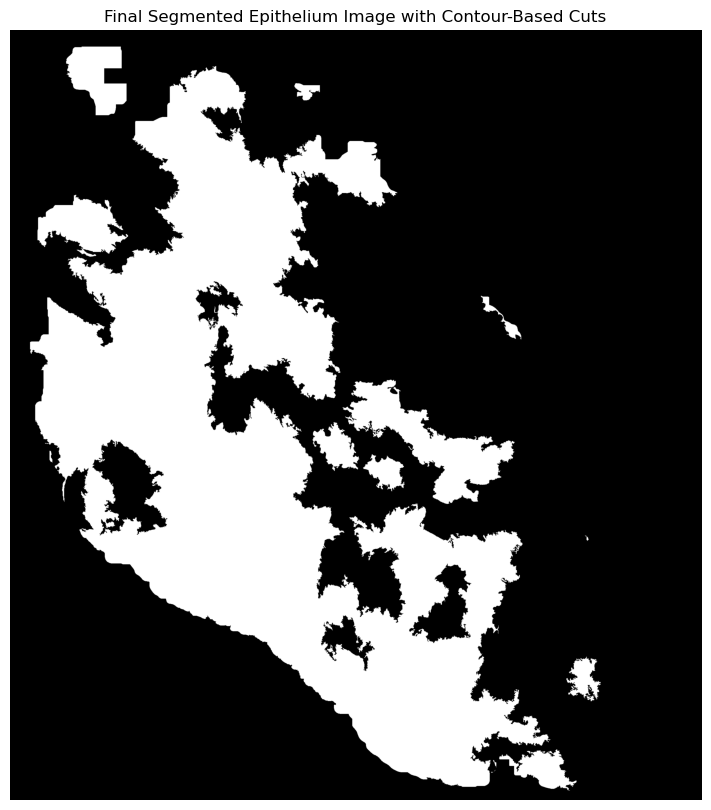

In [13]:
he_ep = combined_contour_superpixel_segmentation('h1810898B_ROI1/h&e.tif')

In [14]:
def color_image_to_binary_mask(image, threshold=128):
    # Check if the image has 3 channels (RGB)
    if image.ndim != 3 or image.shape[2] != 3:
        raise ValueError("Input image must be a 3D color image (height x width x 3).")
    
    # Convert the color image to grayscale (luminosity method)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Threshold the grayscale image to get a binary mask
    _, binary_mask = cv2.threshold(gray_image, threshold, 255, cv2.THRESH_BINARY)
    
    # Convert binary mask to 0 and 1 (optional, depends on your use case)
    binary_mask = binary_mask // 255  # Convert to 0 and 1
    
    return binary_mask

In [15]:
he_ep_mask = color_image_to_binary_mask(he_ep, 1)

In [18]:
# adjusted pipeline
def pipeline_adjusted(mask1, path2, path3):
    mask2 = pipeline_helper(path2)
    mask3 = pipeline_helper(path3)

    # Step 1: Get maximum width and height to resize all three images
    max_width = max(mask1.shape[1], mask2.shape[1], mask3.shape[1])
    max_height = max(mask1.shape[0], mask2.shape[0], mask3.shape[0])

    # Step 2: Resize and pad all masks to the same size
    mask1 = pad_to_size(mask1, (max_width, max_height))
    mask2 = pad_to_size(mask2, (max_width, max_height))
    mask3 = pad_to_size(mask3, (max_width, max_height))

    # Step 3: Find the best rotation for mask2 that maximizes overlap with mask1
    best_overlap_2, angle2 = find_best_rotation_with_flip(mask1, mask2)
    mask2_flipped = mirror_image(mask2, flip2) if flip2 else mask2
    mask2_transformed = rotate_image(mask2_flipped, angle2)

    # Step 4: Find the best rotation and flip for mask3 that maximizes overlap with the transformed mask2
    best_overlap_3, angle3, flip3 = find_best_rotation_with_flip(mask1, mask3)
    mask3_flipped = mirror_image(mask3, flip3) if flip3 else mask3
    mask3_transformed = rotate_image(mask3_flipped, angle3)

    return mask1, mask2, mask3, mask2_transformed, mask3_transformed, angle2, flip2, angle3, flip3


In [19]:
paths = ['patient1/h1810898A h&e_ROI_1.tif', 'patient1/h1810898A mela_ROI_1.tif', 'patient1/h1810898A sox10_ROI_1.tif']
he, melana, sox, melana_rotated, sox_rotated, angle2, flip2, angle3, flip3 = pipeline_with_optimal_flip(paths[0], paths[1], paths[2])

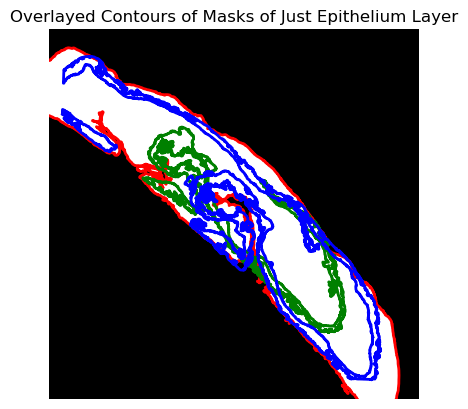

In [20]:
# Find contours for each mask
he_contours = find_contours(he, level=0.5)
melana_contours = find_contours(melana_rotated, level=0.5)
sox_contours = find_contours(sox_rotated, level=0.5)

# Plot the base image (you can choose to use one of the images or any other background)
plt.imshow(he, cmap='gray')  # Replace `he` with the desired base image

# Plot contours of each mask on top of the base image
for contour in he_contours:
    plt.plot(contour[:, 1], contour[:, 0], color='red', lw=2)  # Red contours for H&E

for contour in melana_contours:
    plt.plot(contour[:, 1], contour[:, 0], color='green', lw=2)  # Green contours for melana

for contour in sox_contours:
    plt.plot(contour[:, 1], contour[:, 0], color='blue', lw=2)  # Green contours for melana

# Customize plot (optional)
plt.title('Overlayed Contours of Masks of Just Epithelium Layer')
plt.axis('off')  # Hide axis
plt.show()